In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

import sklearn.preprocessing as preprocessing

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data_nbr = len(data)
print('Number of dayads', data.shape)
data.head()

Number of dayads (146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


# 1. Observation and clean of the data

In [3]:
print('Number of diad: ', len(data))
print('Number of players: ', len(data.playerShort.unique()))
print('Number of referees: ', len(data.refNum.unique()))

Number of diad:  146028
Number of players:  2053
Number of referees:  3147


## 1.1. Missing values

In [4]:
missing = len(data.dropna())
all_ = len(data)
print('Number of rows with missing values: ', missing)
print('Number of row with complete data: {} ({:.3f}%)'.format(all_-missing, (all_ - missing)/all_ ) )


Number of rows with missing values:  115457
Number of row with complete data: 30571 (0.209%)


We cannot just drop all the rows that have at least one missing values, it represent to much data

### Where are the missing values ?

In [5]:
def find_col_nan(d):
    col = []
    for c in d.columns:
        if d[c].isnull().any():
            col = np.append(col, c)
    return col        

In [6]:
missing_col = find_col_nan(data)
missing_col

array(['height', 'weight', 'position', 'photoID', 'rater1', 'rater2',
       'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'], 
      dtype='<U32')

We will clean the nan values that way:
- If both rater1 and rater2 have nan values remove the entry since we cannot guess the value
- If photoID is missing, the raters 1 and 2 should also be missing, we will still check if that is the case.
- replace NAN values in other columns with a default value
    - height & weight with median
    - position with a new position (eg. 'Joker'): if there is no position, we assume that the player don't have a fix position or we don't know where is play. So we assign him a new position: joker, we can take it as a polyvalent player
    - photoID (there is no NAN after removing the NAN ratings)
    - Alpha_3 with 'World': we cannot guess the country of the referee so we assign him 'wolrd'
    - *IAT and *Exp with 0 (we have no values therefore we assume no racial bias)
    

#### If both rater1 and rater2 have nan values remove the entry since we cannot guess the value

In [7]:
data = data[ ~data.rater1.isnull() | ~data.rater2.isnull()]
nbr_clean = len(data)
print('Number of row with at least one rating {} ({:.3f}%)'.format(nbr_clean, nbr_clean/data_nbr))


Number of row with at least one rating 124621 (0.853%)


In [8]:
# check if row with missing photo has at least one rater
rate_without_photo = (data.photoID.isnull() & (~data.rater1.isnull() | ~data.rater2.isnull())).any()
print('Check if it exists rows without photo but with rate? : ', rate_without_photo)

Check if it exists rows without photo but with rate? :  False


Is there still missing values?

In [9]:
find_col_nan(data)

array(['height', 'weight', 'position', 'Alpha_3', 'meanIAT', 'nIAT',
       'seIAT', 'meanExp', 'nExp', 'seExp'], 
      dtype='<U32')

#### Replace others NaN with default values

In [10]:
data['position'] = data['position'].fillna(value="Joker") # all players with no position play the same position
data['Alpha_3'] = data['Alpha_3'].fillna(value="WO") # No country means they play for WOrld ;)

# replace no height and weight with the mean value
median_height = np.median(data['height'].dropna())
median_weight = np.median(data['weight'].dropna())
data['height'] = data['height'].fillna(value=median_height)
data['weight'] = data['weight'].fillna(value=median_weight)

# the IAT stuff, replace all with 0 (meaning no bias). 
data['meanIAT'] = data['meanIAT'].fillna(value=0)
data['nIAT'] = data['nIAT'].fillna(value=0)
data['seIAT'] = data['seIAT'].fillna(value=0)
data['meanExp'] = data['meanExp'].fillna(value=0)
data['nExp'] = data['nExp'].fillna(value=0)
data['seExp'] = data['seExp'].fillna(value=0)

In [11]:
print(np.sum(np.sum(pd.isnull(data))))

0


## 1.2.handling different ratings (rater1 vs rater2)
- We check if there is player with only one rating
- We also check if one rater always give the same rate to the same player
- Now we need to take one single rating for each row. We'll need to investigate a bit more the different rating



- what rating to take:
    - take the rating of the rater where less dissagreement happend. (rater2->0, rater1->1, rater2->2, rater2->3, rater1->4) so if rater2 rated 0 take it... (in order 4, 0, 1, 2, 3)
    - compare taking only rater1 vs rater2
    - make a colum 'color_rating' and remove the other two
    

Is there players with only one rating?

In [12]:
(data.rater1.isnull() | data.rater2.isnull()).any()

False

Are the raters consistent?

In [13]:
def areRaterConsistent(d):
    for playerID in d.playerShort.unique():
  
        player = d[d.playerShort == playerID]
        rater1 = player.rater1.unique()
        rater2 = player.rater2.unique()
        if len(rater1) >1 or len(rater2) > 1:
            return False
    return True  

In [14]:
print("Are the rater consistent: ",areRaterConsistent(data))

Are the rater consistent:  True


### Investigation on the raters

Values of the rating

In [15]:
data.rater1.unique()

array([ 0.25,  0.75,  0.  ,  1.  ,  0.5 ])

Are the raters always agree

In [16]:
print("percentage of players with different ratings: ", len(data[data['rater1'] != data['rater2']])*100 / len(data), "%")

percentage of players with different ratings:  23.195930059941745 %


Let's show some plost to visualize when the rater differe

In [17]:
len(data)

124621

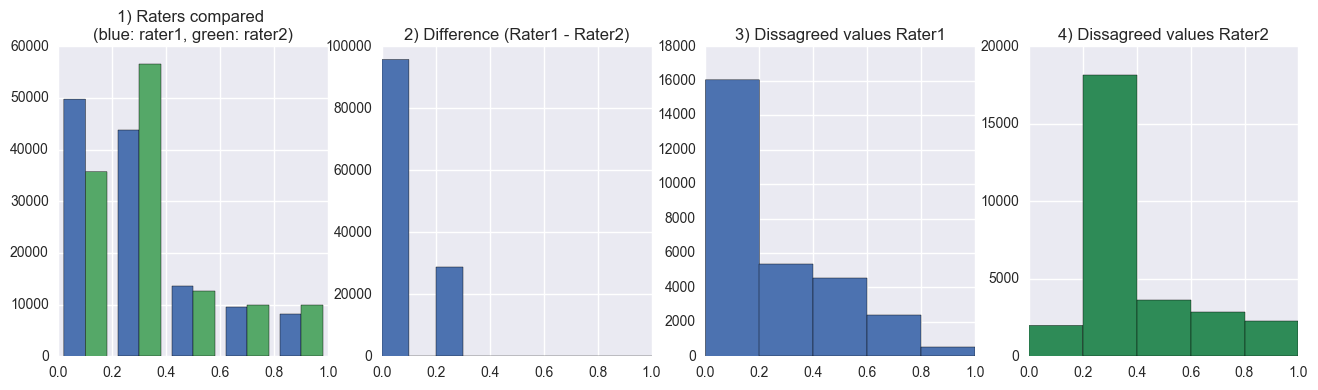

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].hist([data['rater1'], data['rater2']], bins=5)
ax[0].set_title("1) Raters compared \n(blue: rater1, green: rater2)")

ax[1].hist(np.abs(data['rater1'] - data['rater2']), bins=10, range=(0, 1))
ax[1].set_title("2) Difference (Rater1 - Rater2)")

dissagree_data = data[data['rater1'] != data['rater2']]
ax[2].hist(dissagree_data['rater1'], bins=5)
ax[2].set_title("3) Dissagreed values Rater1")

ax[3].hist(dissagree_data['rater2'], bins=5, color='seagreen')
ax[3].set_title("4) Dissagreed values Rater2")

We can see that rater1 and 2 disagree the most when they have to rate "white" people.

We can alos see with graph2 that when there disagree it's ony of one category.


Now we will create a new columns: color_skin that will be our label to guess. To convert the values of rater 1 and 2 in one rate, we need to follow some rules that come from the graph:
    1. if rater1 and rater2 are agree, take that value
    2. We can see on graph 4 that when rater2 give 0, usually, rater1 agrees => so when rater2 give 0, we take that value as the color skin
    3. In graph 3, when rater1 give 1, rater2 usually agrees => when rater1 give 1, take that value as the color_skin
    4. In graph 3, we can see that when rater1 rate1 give 0.25, usually rater2 agrees => take rater1
    5. choose at random between both values
    
    

In [19]:
data['color_rating'] = -1

In [20]:
def color_skin_rules(row):
    #Rule 1
    if row.rater1 == row.rater2:
        return row.rater1
    #Rule2    
    elif row.rater2 == 0:
        return 0
    #Rule 3
    elif row.rater1 == 1:
        return 1
    #Rule 4
    elif row.rater1 == 0.25:
        return 0.25
    else: 
        return np.random.choice([row.rater1, row.rater2])
data.color_rating = data.apply(color_skin_rules, axis=1)


# 2. Train the model  

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score

In [22]:
# encoders
le = pp.LabelEncoder() # for playernames etc.
ohe = pp.OneHotEncoder() # for categories with 'few' categories

In [23]:
data_train = data.copy()

data_train['player_encoded'] = le.fit_transform(data_train['player'])
data_train['club_encoded'] = le.fit_transform(data_train['club'])
data_train['leagueCountry_encoded'] = le.fit_transform(data_train['leagueCountry'])
data_train['birthday_encoded'] = le.fit_transform(data_train['birthday'])
data_train['position_encoded'] = le.fit_transform(data_train['position'])
data_train['Alpha_3_encoded'] = le.fit_transform(data_train['Alpha_3'])
data_train['color_rating_encoded'] = le.fit_transform(data_train['color_rating'])

rf_input_data = data_train[['player_encoded', 'club_encoded', 'leagueCountry_encoded', \
                      'birthday_encoded', 'height', 'weight', 'position_encoded', \
                      'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', \
                      'yellowReds', 'redCards', 'refNum', 'refCountry', 'Alpha_3_encoded', \
                      'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'seExp']]
player_colors = data_train['color_rating_encoded']

rf_input_data.dtypes

player_encoded             int64
club_encoded               int64
leagueCountry_encoded      int64
birthday_encoded           int64
height                   float64
weight                   float64
position_encoded           int64
games                      int64
victories                  int64
ties                       int64
defeats                    int64
goals                      int64
yellowCards                int64
yellowReds                 int64
redCards                   int64
refNum                     int64
refCountry                 int64
Alpha_3_encoded            int64
meanIAT                  float64
nIAT                     float64
seIAT                    float64
meanExp                  float64
seExp                    float64
dtype: object

In [24]:
rf = RandomForestClassifier()
# roc_scorer = make_scorer(roc_curve)
X = rf_input_data
y = player_colors
result = cross_val_score(rf, X, y, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)

"""
kf = KFold(n_splits=10)
for train, test in kf.split(rf_input_data):
    X_train, X_test, y_train, y_test = rf_input_data[train], rf_input_data[test], player_colors[train], player_colors[test]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
"""

result

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.852616 -   0.1s
[CV] ....................................... , score=0.901958 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.893854 -   0.1s
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.895354 -   0.1s
[CV]  ................................................................
[CV] ....................................... , score=0.896341 -   0.1s
[CV] ....................................... , score=0.889032 -   0.1s
[CV]  ................................................................
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   18.7s finished


array([ 0.85261553,  0.90195764,  0.8938543 ,  0.89634146,  0.88903153,
        0.8953535 ,  0.90233529,  0.90529695,  0.89606742,  0.82800963])

## Observe the important features

In [25]:
rf.fit(rf_input_data, player_colors)
imp_features = rf.feature_importances_
cols = rf_input_data.columns
for i in range(0, len(imp_features)):
    print(cols[i], " -> ", imp_features[i])

player_encoded  ->  0.155803291643
club_encoded  ->  0.124371658318
leagueCountry_encoded  ->  0.0331255207136
birthday_encoded  ->  0.14805755416
height  ->  0.117960066472
weight  ->  0.124136486955
position_encoded  ->  0.0879510762876
games  ->  0.0190814011569
victories  ->  0.0179283407693
ties  ->  0.0129722077505
defeats  ->  0.0148331879884
goals  ->  0.0105421831811
yellowCards  ->  0.0103593731959
yellowReds  ->  0.000859141408433
redCards  ->  0.000880001586211
refNum  ->  0.0502454288831
refCountry  ->  0.00997323283899
Alpha_3_encoded  ->  0.0102483346369
meanIAT  ->  0.010803632264
nIAT  ->  0.00874803885687
seIAT  ->  0.00999903250858
meanExp  ->  0.0110279816584
seExp  ->  0.0100928267663


We can see that the most important feature are:
    - name of the player
    - the club
    - the league country
    - the birthday
    
Those result seemms weird. Indeed it look weird that it is possible to guess the color skin of a player based mainly on those 4 feautures. The birthday should not be deterministic since the color skin and the birthday are suppose to be 2 independant variable. Same for the name or the club. It would be quite strange if knowing the club we would be able to predict the color skin of a player, even if it is possible that some club have more "black" or "white" poeple    

We have to remember that our data contains dayads between player and referee, so it's mean that a player can appear several time in our data. It could be the reason why the name is deterministic. let's see some fact about the data

In [26]:
data.playerShort.value_counts()[:10]

djibril-cisse           202
john-arne-riise         197
javier-saviola          196
giorgios-karagounis     195
xavi                    188
helder-postiga          183
zlatan-ibrahimovic      181
rafael-van-der-vaart    181
simao                   180
ian-harte               177
Name: playerShort, dtype: int64

Indeed, some player appear 200 times, so it is easy to determine the color skin of djibril cisse if he appears both in the training set and in the test set. But in the reality the probability to have 2 djibril cisse with the same birthday and same color skin is almost null

One solution is to group the data by player name. Then we need to find a solution to correctly group the remaining features:
    - club: we have to check if a player appear in 2 different club (in case of a transfer during the winter mercato) or if the transfer are not taking into account. (-> one (several) hot encoding. or majority dyads per club)
    - leagueCountry: same as club
    - position: test if the player as different -> position with the majority of game? 
    - photoID: drop that information, the id is unique -> not relevant for our classification probleme
    - refNum: replace with the total of unique refs
    - refCountry: same as refNum
    - Alpha_3: remove: redundant information since it correspond to the refCountry
    - meanIAT: make new features
        - take mean 
        - take weighted mean (weight with nIAT)
        - take weighted mean (weight with game numers)
    - meanExp: same as IAT
    - seAIT: 
    - seExp:

In [27]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'color_rating'],
      dtype='object')

In [30]:
clubUnique = True
leagueUnique = True
positionUnique = True

def checkFunction(player):
    #check if the club is unique for one player
    if len(player.club.unique()) > 1:
        clubUnique = False
        print(player.player, 'plays for more than one team: ', player.club.unique())
    #check if the leagueCountry is unique
    if len(player.leagueCountry.unique()) > 1:
        leagueUnique = False
        print(player.player, 'plays for more than one league: ', player.leagueCountry.unique())
    #check if the position is unique
    if len(player.position.unique()) > 1:
        positionUnique = False
        print(player.player, 'plays for more than one position: ', player.position.unique())

    
data_group = pd.groupby(data, by=data.playerShort).apply(checkFunction)
print("Is the club for a player unique? ", clubUnique)
print("Is the league for a player unique? ", leagueUnique)
print("Is the position for a player unique? ", positionUnique)


Is the club for a player unique?  True
Is the league for a player unique?  True
Is the position for a player unique?  True


List of the columns

In [76]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'color_rating'],
      dtype='object')

In [145]:
def aggreagtion(df):
    first_entry = df.head(1)
    # new aggregation entry
    new_entry = first_entry.copy()
    
    #sum of the info about the games
    new_entry.games = df.games.sum()
    new_entry.victories = df.victories.sum()
    new_entry.ties = df.ties.sum()
    new_entry.defeats = df.defeats.sum()
    new_entry.goals = df.goals.sum()
    new_entry.yellowCards = df.yellowCards.sum()
    new_entry.yellowReds = df.yellowReds.sum()
    new_entry.redCards = df.redCards.sum()
    
    #drop photoID and alpha_3
    new_entry.drop('photoID', inplace = True, axis=1)
    new_entry.drop('Alpha_3', inplace = True, axis=1)
    #refNum: number of unique ref
    new_entry = new_entry.rename(columns = {'refNum': 'refCount'})
    new_entry.refCount = len(df.refNum.unique()) 
    #refCountry: replace by number of unique country
    new_entry = new_entry.rename(columns = {'refCountry': 'refCountryCount'})
    new_entry.refCountryCount = len(df.refCountry.unique())
    
    #==Mean of the test result ===
    #- take mean 
    #- take weighted mean (weight with nIAT)
    #- take weighted mean (weight with game numers)
    
    new_entry.meanIAT = df.meanIAT.mean()
    new_entry.meanExp = df.meanExp.mean()
    
    new_entry['meanIAT_nIAT'] = (df.meanIAT * df.nIAT).sum() / df.nIAT.sum() 
    new_entry['meanExp_nExp'] = (df.meanExp * df.nExp) / df.nExp.sum()
    
    new_entry['meanIAT_GameNbr'] = (df.meanIAT * df.games) / df.games.sum()
    new_entry['meanExp_GameNbr'] = (df.meanExp * df.games) / df.games.sum()
    
    
    #????????????????????? DROP nIART nExp or NOT ?????????????????????????????
    new_entry.drop('nIAT', inplace = True, axis=1)
    new_entry.drop('nExp', inplace = True, axis=1)
    
    # standard error = standard deviation / sqrt(n)
    #mean of the standard deviation: mean of the variance and then sqrt
    #varIAT = (df.seIAT * np.sqrt(df.nIAT)) ** 2
    #new_entry.seIAT = np.sqrt(np.mean(varIAT))/ np.sqrt(df.nIAT)
    #varExp = (df.seExp * np.sqrt(df.nExp)) ** 2
    #new_entry.seExp = np.sqrt(np.mean(varExp))/ np.sqrt(df.nExp)
    return new_entry
    

In [146]:
data_agr = pd.groupby(data, by=data.playerShort).apply(aggreagtion)
data_agr

,,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr
playerShort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,654,247,179,228,9,19,0,0,0.25,0.00,166,37,0.346459,0.003297,0.494575,0.013752,0.00,0.328409,2.043326e-05,0.000497,0.000823
aaron-hunt,745,aaron-hunt,Aaron Hunt,Werder Bremen,Germany,04.09.1986,183.0,73.0,Attacking Midfielder,336,141,73,122,62,42,0,1,0.00,0.25,99,25,0.348818,0.003297,0.449220,0.013752,0.25,0.329945,2.631994e-05,0.001936,0.003205
aaron-lennon,746,aaron-lennon,Aaron Lennon,Tottenham Hotspur,England,16.04.1987,165.0,63.0,Right Midfielder,412,200,97,115,31,11,0,0,0.25,0.25,101,28,0.345893,0.003297,0.491482,0.013752,0.25,0.328230,3.116495e-05,0.001579,0.002614
aaron-ramsey,747,aaron-ramsey,Aaron Ramsey,Arsenal FC,England,26.12.1990,178.0,76.0,Center Midfielder,260,150,42,68,39,31,0,1,0.00,0.00,104,37,0.346821,0.003297,0.514693,0.013752,0.00,0.327775,1.694555e-05,0.002501,0.004142
abdelhamid-el-kaoutari,4418,abdelhamid-el-kaoutari,Abdelhamid El-Kaoutari,Montpellier HSC,France,17.03.1990,180.0,73.0,Center Back,124,41,40,43,1,8,4,2,0.25,0.25,37,11,0.331600,0.000151,0.335587,0.000586,0.25,0.338847,9.259598e-03,0.016194,0.016263
abdou-traore_2,2305,abdou-traore_2,Abdou Traoré,Girondins Bordeaux,France,17.01.1988,180.0,74.0,Right Midfielder,97,41,23,33,3,11,1,0,0.75,0.75,42,13,0.320079,0.000229,0.296562,0.001002,0.75,0.332117,5.604126e-03,0.003813,0.006065
abdoulaye-diallo_2,47,abdoulaye-diallo_2,Abdoulaye Diallo,Stade Rennes,France,30.03.1992,189.0,80.0,Goalkeeper,24,8,8,8,0,0,0,0,0.75,1.00,20,5,0.341625,0.000151,0.400818,0.000586,0.75,0.337572,1.831674e-02,0.013945,0.014004
abdoulaye-keita_2,4423,abdoulaye-keita_2,Abdoulaye Keita,Girondins Bordeaux,France,19.08.1990,188.0,83.0,Goalkeeper,3,0,1,2,0,0,0,0,0.75,1.00,2,2,0.355406,0.000151,0.417225,0.000586,0.75,0.341567,2.797899e-01,0.223123,0.224067
abdoulwhaid-sissoko,4424,abdoulwhaid-sissoko,Abdoulwhaid Sissoko,Stade Brest,France,20.03.1990,180.0,68.0,Defensive Midfielder,121,34,25,62,3,21,0,2,1.00,1.00,56,3,0.348178,0.000151,0.429630,0.000586,1.00,0.344426,6.968737e-03,0.008298,0.008333


# 3. Machine learning

In [142]:
# encoders
le = pp.LabelEncoder() # for playernames etc.
ohe = pp.OneHotEncoder() # for categories with 'few' categories

In [147]:
data_agr = data_agr.copy()

data_agr['player_encoded'] = le.fit_transform(data_agr['player'])
data_agr['club_encoded'] = le.fit_transform(data_agr['club'])
data_agr['leagueCountry_encoded'] = le.fit_transform(data_agr['leagueCountry'])
data_agr['birthday_encoded'] = le.fit_transform(data_agr['birthday'])
data_agr['position_encoded'] = le.fit_transform(data_agr['position'])
data_agr['color_rating_encoded'] = le.fit_transform(data_agr['color_rating'])

rf_input_data = data_agr[['player_encoded', 'club_encoded', 'leagueCountry_encoded', \
                      'birthday_encoded', 'height', 'weight', 'position_encoded', \
                      'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', \
                      'yellowReds', 'redCards', 'refCount', 'refCountryCount', \
                      'meanIAT', 'seIAT', 'meanExp', 'seExp','meanIAT_nIAT', 'meanExp_nExp', \
                      'meanIAT_GameNbr', 'meanExp_GameNbr']]
player_colors = data_agr['color_rating_encoded']

rf_input_data.dtypes


player_encoded             int64
club_encoded               int64
leagueCountry_encoded      int64
birthday_encoded           int64
height                   float64
weight                   float64
position_encoded           int64
games                      int64
victories                  int64
ties                       int64
defeats                    int64
goals                      int64
yellowCards                int64
yellowReds                 int64
redCards                   int64
refCount                   int64
refCountryCount            int64
meanIAT                  float64
seIAT                    float64
meanExp                  float64
seExp                    float64
meanIAT_nIAT             float64
meanExp_nExp             float64
meanIAT_GameNbr          float64
meanExp_GameNbr          float64
dtype: object

In [148]:
np.max(rf_input_data, axis=0)

player_encoded           1571.000000
club_encoded               96.000000
leagueCountry_encoded       3.000000
birthday_encoded         1388.000000
height                    203.000000
weight                    100.000000
position_encoded           12.000000
games                     914.000000
victories                 527.000000
ties                      197.000000
defeats                   259.000000
goals                     420.000000
yellowCards               197.000000
yellowReds                 12.000000
redCards                   13.000000
refCount                  202.000000
refCountryCount            55.000000
meanIAT                     0.413096
seIAT                       0.073330
meanExp                     1.122201
seExp                       0.148467
meanIAT_nIAT                0.396512
meanExp_nExp                1.031407
meanIAT_GameNbr             0.396512
meanExp_GameNbr             1.031407
dtype: float64

In [149]:
rf = RandomForestClassifier()
# roc_scorer = make_scorer(roc_curve)
X = rf_input_data
y = player_colors
result = cross_val_score(rf, X, y, cv=10, n_jobs=3, pre_dispatch='n_jobs+1', verbose=3)

"""
kf = KFold(n_splits=10)
for train, test in kf.split(rf_input_data):
    X_train, X_test, y_train, y_test = rf_input_data[train], rf_input_data[test], player_colors[train], player_colors[test]
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
"""

result

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.331250 -   0.0s
[CV] ....................................... , score=0.418750 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.389937 -   0.0s
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................................... , score=0.402516 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.440252 -   0.0s
[CV]  ................................................................
[CV] ....................................... , score=0.443038 -   0.0s
[CV]  

[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished


array([ 0.33125   ,  0.41875   ,  0.38993711,  0.40251572,  0.44025157,
        0.44025157,  0.44303797,  0.42405063,  0.44585987,  0.41666667])